In [1]:
!pip -q install scikit-image scipy

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import pi
from fractions import Fraction
from google.colab import files

from skimage.metrics import structural_similarity as ssim
from skimage.filters import threshold_otsu
from skimage.morphology import (
    opening, remove_small_objects, binary_dilation, disk, footprint_rectangle,
)
from scipy.optimize import minimize
import time

➡️ 실험에서 얻은 리사주 이미지 1장을 업로드(.png/.jpg)


Saving sample lissajous picture.PNG to sample lissajous picture (1).PNG


/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-458116312.py:30: UserWarning: Glyph 44201 (\N{HANGUL SYLLABL

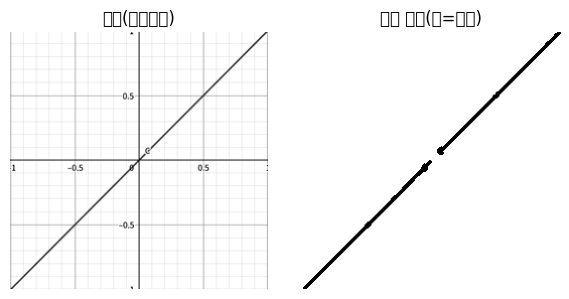

In [44]:
# 0) 업로드 + 격자 제거 전처리
def remove_grid_from_pil(pil_img, side=256, h_scale=12, min_obj=150, dilate_px=1):
    img = pil_img.convert('L').resize((side, side), Image.BILINEAR)
    arr = np.array(img)
    th = threshold_otsu(arr)
    binary = (arr < th)  # True=선
    h_len = max(8, side // h_scale)
    grid_h = opening(binary, footprint=footprint_rectangle((1, h_len)))
    grid_v = opening(binary, footprint=footprint_rectangle((h_len, 1)))
    grid = np.logical_or(grid_h, grid_v)
    curve_only = np.logical_and(binary, np.logical_not(grid))
    curve_only = remove_small_objects(curve_only, min_size=min_obj)
    if dilate_px > 0:
        curve_only = binary_dilation(curve_only, footprint=disk(dilate_px))
    out = np.ones_like(arr, dtype=np.uint8) * 255
    out[curve_only] = 0
    return out

print("➡️ 실험에서 얻은 리사주 이미지 1장을 업로드(.png/.jpg)")
uploaded = files.upload()
fname = next(iter(uploaded))

SIDE = 256
orig = Image.open(fname)
target_img = remove_grid_from_pil(orig, side=SIDE, h_scale=12, min_obj=200, dilate_px=1)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(orig.convert('L').resize((SIDE,SIDE)), cmap='gray'); plt.title("원본(리사이즈)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(target_img, cmap='gray'); plt.title("격자 제거(선=검정)"); plt.axis('off')
plt.tight_layout(); plt.show()

In [46]:
# 1) Lissajous
def lissajous(a, b, delta=0.0, n=2000, tmax=2*np.pi):
    t = np.linspace(0, tmax, n)
    x = np.sin(a*t + delta)
    y = np.sin(b*t)
    return x, y

def rotate_points(x, y, theta):
    c, s = np.cos(theta), np.sin(theta)
    return c*x - s*y, s*x + c*y

In [47]:
# 2) 곡선을 흑백 이미지로 래스터화 (얇은 폴리라인)
def render_curve_image(x, y, size=256, margin=0.06):
    # [-1,1] 정규화 → 폴리라인 래스터
    x = x / (np.max(np.abs(x)) + 1e-9)
    y = y / (np.max(np.abs(y)) + 1e-9)
    img = np.ones((size, size), dtype=np.uint8) * 255
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin).astype(int)
    py = ((1-(y+1)/2) * s + size*margin).astype(int)
    def line_pixels(r0, c0, r1, c1):
        rr, cc = [], []
        dr = abs(r1 - r0); dc = abs(c1 - c0)
        sr = 1 if (r1 - r0) >= 0 else -1
        sc = 1 if (c1 - c0) >= 0 else -1
        if dc > dr:
            err = dc // 2; r = r0
            for c in range(c0, c1+sc, sc):
                if 0<=r<size and 0<=c<size: rr.append(r); cc.append(c)
                err -= dr
                if err < 0: r += sr; err += dc
        else:
            err = dr // 2; c = c0
            for r in range(r0, r1+sr, sr):
                if 0<=r<size and 0<=c<size: rr.append(r); cc.append(c)
                err -= dc
                if err < 0: c += sc; err += dr
        return np.array(rr), np.array(cc)
    for i in range(1, len(px)):
        rr, cc = line_pixels(py[i-1], px[i-1], py[i], px[i])
        img[rr, cc] = 0
    return img

# ---------- 2) 유사도 (SSIM + Dice 선택) ----------
def dice_coeff(img1, img2):
    a = (img1 == 0); b = (img2 == 0)
    inter = np.logical_and(a, b).sum()
    return 2*inter / (a.sum() + b.sum() + 1e-9)

def compare_images(target, cand, use_combo=True):
    ssim_score = ssim(target, cand, data_range=255)
    if not use_combo:
        return ssim_score, ssim_score
    dice = dice_coeff(target, cand)
    combo = 0.3*ssim_score + 0.7*dice  # 격자 잔여/굵기 차이에 더 강건
    return combo, ssim_score

In [54]:
# 3) 고정 비(a:b)에서 위상 δ만 최적화
def best_phase_for_ratio(target_img, a, b,
                         coarse_steps=181,   # 2π를 1도 간격 수준으로 스캔
                         try_rotations=True, try_swap=True,
                         refine=True):
    angles = np.linspace(0, np.pi, 9) if try_rotations else [0.0]
    pairs = [(a, b)] + ([(b, a)] if try_swap else [])
    best = {'score': -1, 'ssim': -1, 'a': None, 'b': None,
            'delta': None, 'theta': None, 'swapped': False}

    # --- Coarse: δ ∈ [0, 2π) 스캔 ---
    print(f"  ▷ Coarse δ-scan for ratio {a}:{b}")
    deltas = np.linspace(0, 2*np.pi, coarse_steps, endpoint=False)
    tic = time.time()
    for d in deltas:
        for (aa, bb) in pairs:
            x, y = lissajous(aa, bb, delta=d, n=1600)
            for th in angles:
                xr, yr = rotate_points(x, y, th)
                cand = render_curve_image(xr, yr, size=target_img.shape[0])
                combo, ssim_only = compare_images(target_img, cand, use_combo=True)
                if combo > best['score']:
                    best.update({'score': combo, 'ssim': ssim_only, 'a': aa, 'b': bb,
                                 'delta': d, 'theta': th, 'swapped': (aa!=a or bb!=b)})
    print(f"    → coarse best δ≈{best['delta']:.4f} rad ({np.degrees(best['delta']):.1f}°), "
          f"SSIM={best['ssim']:.4f}, combo={best['score']:.4f}  (elapsed {time.time()-tic:.1f}s)")

    # refine 단계 생략 옵션
    if not refine:
        return best

    # --- Refine: δ만 연속 최적화 (회전/스왑은 coarse 결과 고정) ---
    def neg_score(d):
        x, y = lissajous(best['a'], best['b'], delta=d[0], n=2000)
        xr, yr = rotate_points(x, y, best['theta'])
        cand = render_curve_image(xr, yr, size=target_img.shape[0])
        combo, ssim_only = compare_images(target_img, cand, use_combo=True)
        return -combo

    res = minimize(neg_score, x0=[best['delta']], method='Nelder-Mead',
                   options={'maxiter': 100, 'xatol':1e-3, 'fatol':1e-4})
    d_star = res.x[0] % (2*np.pi)

    # 평가 갱신
    x, y = lissajous(best['a'], best['b'], delta=d_star, n=2000)
    xr, yr = rotate_points(x, y, best['theta'])
    cand = render_curve_image(xr, yr, size=target_img.shape[0])
    combo, ssim_only = compare_images(target_img, cand, use_combo=True)
    best.update({'delta': d_star, 'score': combo, 'ssim': ssim_only})

    return best, cand


In [55]:
# 4) 원하는 비(들) 평가
ratios = [(1,1), (1,2), (1,3), (2,3), (3,4)]  # 여기서 골라 쓰면 됨

results = []
best_global = None
for (a,b) in ratios:
    r, cand = best_phase_for_ratio(target_img, a, b,
                                   coarse_steps=181, try_rotations=True, try_swap=True, refine=True)
    results.append((a,b,r))
    if (best_global is None) or (r['score'] > best_global['score']):
        best_global = r
        best_cand_img = cand


  ▷ Coarse δ-scan for ratio 1:1
    → coarse best δ≈3.1242 rad (179.0°), SSIM=0.9614, combo=0.7094  (elapsed 55.1s)
  ▷ Coarse δ-scan for ratio 1:2
    → coarse best δ≈6.2138 rad (356.0°), SSIM=0.8280, combo=0.2773  (elapsed 53.6s)
  ▷ Coarse δ-scan for ratio 1:3
    → coarse best δ≈6.2485 rad (358.0°), SSIM=0.8523, combo=0.2916  (elapsed 54.0s)
  ▷ Coarse δ-scan for ratio 2:3
    → coarse best δ≈2.3605 rad (135.2°), SSIM=0.8557, combo=0.2716  (elapsed 55.3s)
  ▷ Coarse δ-scan for ratio 3:4
    → coarse best δ≈1.5621 rad (89.5°), SSIM=0.8258, combo=0.2623  (elapsed 55.0s)



===== Summary (known ratio → optimal phase) =====
1:1 → δ ≈ 3.1321 rad (179.46°), SSIM=0.9670, combo=0.7713, rot=90.0°, swapped=False
1:2 → δ ≈ 6.2238 rad (356.60°), SSIM=0.8277, combo=0.2803, rot=22.5°, swapped=True
1:3 → δ ≈ 6.2547 rad (358.37°), SSIM=0.8541, combo=0.2975, rot=22.5°, swapped=True
2:3 → δ ≈ 2.3594 rad (135.18°), SSIM=0.8558, combo=0.2717, rot=45.0°, swapped=True
3:4 → δ ≈ 1.5624 rad (89.52°), SSIM=0.8260, combo=0.2625, rot=135.0°, swapped=True

 BEST MATCH
ratio 1:1, δ ≈ 3.1321 rad (179.46°), SSIM=0.9670, combo=0.7713, rot=90.0°, swapped=False


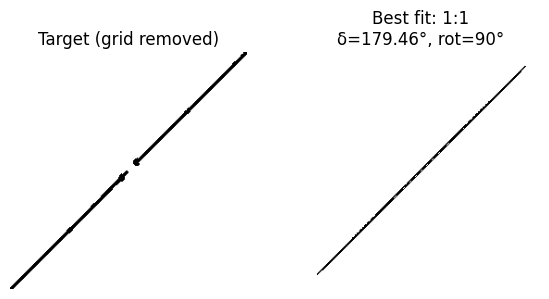

In [56]:
# 5) 결과 요약
print("\n===== Summary (known ratio → optimal phase) =====")
for (a,b,r) in results:
    print(f"{a}:{b} → δ ≈ {r['delta']:.4f} rad ({np.degrees(r['delta']):.2f}°), "
          f"SSIM={r['ssim']:.4f}, combo={r['score']:.4f}, "
          f"rot={np.degrees(r['theta']):.1f}°, swapped={r['swapped']}")

print("\n BEST MATCH")
print(f"ratio {best_global['a']}:{best_global['b']}, "
      f"δ ≈ {best_global['delta']:.4f} rad ({np.degrees(best_global['delta']):.2f}°), "
      f"SSIM={best_global['ssim']:.4f}, combo={best_global['score']:.4f}, "
      f"rot={np.degrees(best_global['theta']):.1f}°, swapped={best_global['swapped']}")

# 시각화: 타깃 vs best-fit
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(target_img, cmap='gray'); axes[0].set_title("Target (grid removed)"); axes[0].axis('off')
axes[1].imshow(best_cand_img, cmap='gray')
axes[1].set_title(f"Best fit: {best_global['a']}:{best_global['b']}\nδ={np.degrees(best_global['delta']):.2f}°, rot={np.degrees(best_global['theta']):.0f}°")
axes[1].axis('off')
plt.tight_layout(); plt.show()